# APRESENTAÇÃO

Olá, sou Ítalo Alves, 27 anos, formado em 2018 no curso de Engenharia Mecânica pela Universidade Federal de Pernambuco (UFPE) e atualmente mestrando em Ciência de Dados/Inteligência Computacional pela mesma instituição.

Redes Sociais:

[Linkedin](https://www.linkedin.com/in/italoalvesc/)

[GitHub](https://github.com/italooalves)

# 1.0 INTRODUÇÃO

A avaliação do desafio do processo seletivo será composta por duas macro tarefas, são elas:

**1 - Análise descritiva dos dados (EDA):**


1.   Construa uma análise descritiva extraindo conhecimento das variáveis e apresentando quais insights podem ser obtidos a partir delas;
2.   Mostre-nos um caminho para selecionar graficamente as variáveis mais ou menos importantes para cada problema, como elas se relacionam e porquê.
3. Em cada problema descreva quais outras técnicas poderiam ser aplicadas e porquê você não as escolheu.
4. Utilize os dados: eda_receitas_data.zip


**2 - Teste técnico de modelagem**

Nessa parte, será necessário implementar um algoritmo de acordo com o paradigma do problema. Cada problema tem um conjunto de métricas que são requeridas. A variável alvo sempre será a coluna de nome “target”, exceto para os problemas não-supervisionados.

1. Construa um classificador e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

      a. métricas: precision, recall e F1-score;

      b. dados: classification_data.zip;

2. Selecione um sku (produto) e realize uma previsão da demanda do mesmo nos próximos 4 intervalos de tempo de sua escolha (dia, semana, mês, etc) 

      a. métricas: rmse, mape;

      b. dados: time_series_data.xlsx;

3. Construa um regressor e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

      a. métricas: RMSE, R2 e cor(target_observado, target_predito);

      b. dados: regression_data.zip.





# 2.0 BIBLIOTECAS E FUNÇÕES

## 2.1 BIBLIOTECAS

In [62]:
import json
import math
import numpy  as np
import pandas as pd
import random
import warnings
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from datetime              import datetime, timedelta

from sklearn.linear_model       import LogisticRegression
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import mean_absolute_error, mean_squared_error
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics            import plot_confusion_matrix,confusion_matrix, classification_report,accuracy_score as score, explained_variance_score as evs
from sklearn.tree               import DecisionTreeClassifier
from sklearn.model_selection    import GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble           import RandomForestRegressor
from sklearn.metrics            import r2_score
from sklearn.model_selection    import cross_val_score

warnings.filterwarnings( 'ignore' )

## 2.2 FUNÇÕES

In [111]:
def desc_num(num_attributes):
  # Central Tendency - mean, meadina 
  ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
  ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

  # dispersion - std, min, max, range, skew, kurtosis
  d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
  d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
  d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
  d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
  d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
  d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

  # concatenar
  m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
  m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'assimetria', 'curtose']
  return m


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# 3.0 CARREGANDO OS DADOS

In [4]:
# Dados para Classificação
raw_df_class_test = pd.read_csv('https://raw.githubusercontent.com/italooalves/PS_ONCASE_ITALO/main/Dados/classification_test.csv')
raw_df_class_train = pd.read_csv('https://raw.githubusercontent.com/italooalves/PS_ONCASE_ITALO/main/Dados/classification_train.csv')

# Dados para Regreção
raw_df_reg_test = pd.read_csv('https://raw.githubusercontent.com/italooalves/PS_ONCASE_ITALO/main/Dados/regression_test.csv')
raw_df_reg_train = pd.read_csv('https://raw.githubusercontent.com/italooalves/PS_ONCASE_ITALO/main/Dados/regression_train.csv')

# Dados para serie temporal
raw_df_time_series = pd.read_csv('https://raw.githubusercontent.com/italooalves/PS_ONCASE_ITALO/main/Dados/time_series_data.csv', sep = ';')

# Dados receitas
raw_df_receitas = pd.read_json('receitas.json')

# 4.0 ANÁLISE DESCRITIVA DOS DADOS

Nesta etapa vamos explorar e entender os dados do desafio, entendeo dimensões, natureza, estatística e entre outros.

## 4.1 DADOS DE CLASSIFICAÇÃO

In [5]:
# Copia de segurança
df1 = raw_df_class_train.copy()

In [6]:
df1.head(5)

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


### 4.1.1 DIMENSÃO

In [7]:
print( 'Número de observações: {}'.format( df1.shape[0] ) )
print( 'Número de variáveis: {}'.format( df1.shape[1] ) )

Número de observações: 670
Número de variáveis: 3


### 4.1.2 TIPOLOGIA DOS DADOS

In [8]:
df1.dtypes

x1        float64
x2        float64
target      int64
dtype: object

### 4.1.3 DADOS AUSENTES

In [9]:
df1.isna().sum()

x1        0
x2        0
target    0
dtype: int64

O conjunto de dados não possui nenhum dado faltante.

### 4.1.4 DESCRIÇÃO ESTATÍSTICA E OUTROS

In [10]:
m = desc_num(df1)
m

,attributes,min,max,range,mean,median,std,assimetria,curtose
0,x1,-1.939767,2.590410,4.530178,0.481824,0.492489,0.914089,-0.053647,-0.678747
1,x2,-1.313970,1.904169,3.218139,0.262611,0.275538,0.614564,-0.069489,-0.445338
2,target,0.000000,1.000000,1.000000,0.505970,1.000000,0.499964,-0.023936,-2.005422


Com a tabela anterior, obtemos as informações gerais estatística do conjunto de dados de classificação. Não foi identificado a presença de dados aberrantes.

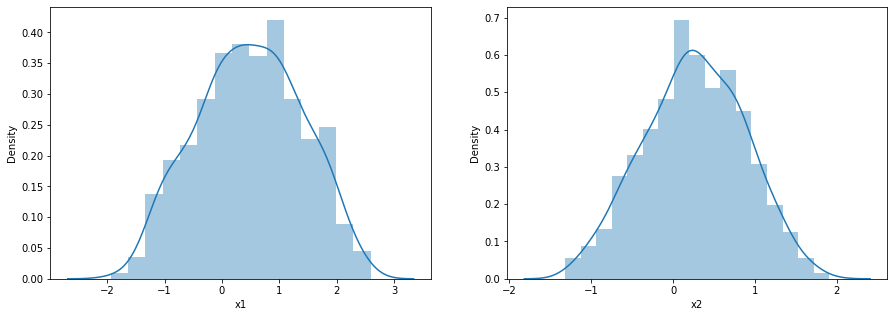

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.title('Histograma dos dados x1 e x2.')

plt.subplot( 1, 2, 1 )
sns.distplot( df1['x1'], kde=True )

plt.subplot( 1, 2, 2 )
sns.distplot( df1['x2'], kde=True )

plt.show()

Na figura anterior, observamos a distribuição das variáveis X1 e X2.

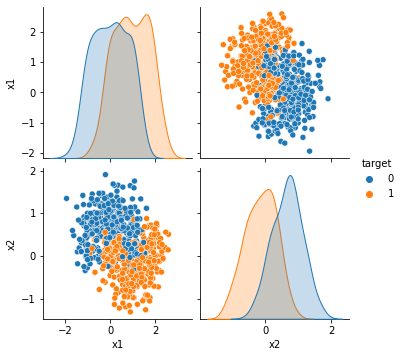

In [12]:
sns.pairplot(df1, hue="target")

Observando o gráfico anterior, conseguimos tirar algumas conclusões como um balanceamento e uma separabilidade da base de dados.

### 4.1.5 CORRELAÇÕES

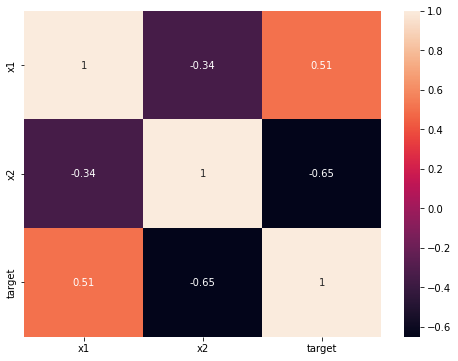

In [13]:
corr_df = df1.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

O mapa de calor da correlação entre as variáveis nos mostra que X1 e X2 possuem uma correlação boa com o nosso target. Dessa forma, serão importantes para o modelo de classificação. Além disso, não possuem uma correlação tão alta entre elas a ponto de não precisar de uma delas.

## 4.2 DADOS PARA REGRESSÃO

In [14]:
#Copia de segurança
df2 = raw_df_reg_train.copy()

In [15]:
df2.head(5)

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


### 4.2.1 DIMENSÃO

In [16]:
print( 'Número de observações: {}'.format( df2.shape[0] ) )
print( 'Número de variáveis: {}'.format( df2.shape[1] ) )

Número de observações: 1042
Número de variáveis: 8


### 4.2.2 TIPOLOGIA DOS DADOS

In [17]:
df2.dtypes

target    float64
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6          int64
X7        float64
dtype: object

Com relação à tipologia dos dados, temos majoritariamente dados float e apenas uma variável do tipo inteira.

### 4.2.3 DADOS AUSENTES

In [18]:
df2.isna().sum()

target    327
X1          0
X2         11
X3          0
X4          0
X5          0
X6          0
X7          0
dtype: int64

O nosso target possui aproximadamente 31% dos dados faltantes. Além disso, na variável X2 temos 11 dados faltantes, o que representa aproximadamente 1% do conjunto de dados.


Dessa forma, é preciso criar uma estratégia para preencher os dados faltantes do nosso target e por opção excluir os dados faltantes da variável X2. 


Talvez uma das melhores formas para preencher seria construir um modelo preditivo para os valores faltantes. No entanto, vamos usar a técnica de substituir pela média. Essa técnica aplicada a aproximadamente 31% dos dados pode causar um enviesamento no modelo de machine learning, porém será observado posteriormente.


#### 4.2.3.1 TRATANDO DADOS FALTANTES

In [19]:
#Média dos targets
targer_media = df2['target'].mean()

#Preenchendo com a média
df2['target'].fillna(targer_media, inplace = True)

#Excluindo os dados Faltantes de X2.
df2.dropna(subset = ['X2'], inplace = True)

In [20]:
df2.isna().sum()

target    0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
dtype: int64

### 4.2.4 DESCRIÇÃO ESTATÍSTICA E OUTROS

In [21]:
m2 = desc_num(df2)
m2

,attributes,min,max,range,mean,median,std,assimetria,curtose
0,target,0.062551,10382.469480,10382.406929,1349.940229,1349.940229,1325.837716,2.579725,9.600942
1,X1,-8.699406,12.380693,21.080098,2.401642,2.500626,3.181916,-0.054729,-0.040411
2,X2,-13.651540,12.926106,26.577645,-0.460781,-0.461150,4.424139,0.051388,0.152477
3,X3,38.035456,62.972372,24.936916,49.937480,49.910884,4.032236,-0.008419,-0.227115
4,X4,0.002360,18.813009,18.810649,2.454212,1.651691,2.537278,1.998634,5.480466
5,X5,-121.450423,53.919202,175.369625,-65.284883,-65.336077,9.074746,1.717083,32.235412
6,X6,0.000000,8.000000,8.000000,4.428710,5.000000,3.274762,-0.345165,-1.450587
7,X7,-69.835905,30.376348,100.212254,-1.330695,-1.124598,11.071898,-0.570031,3.270240


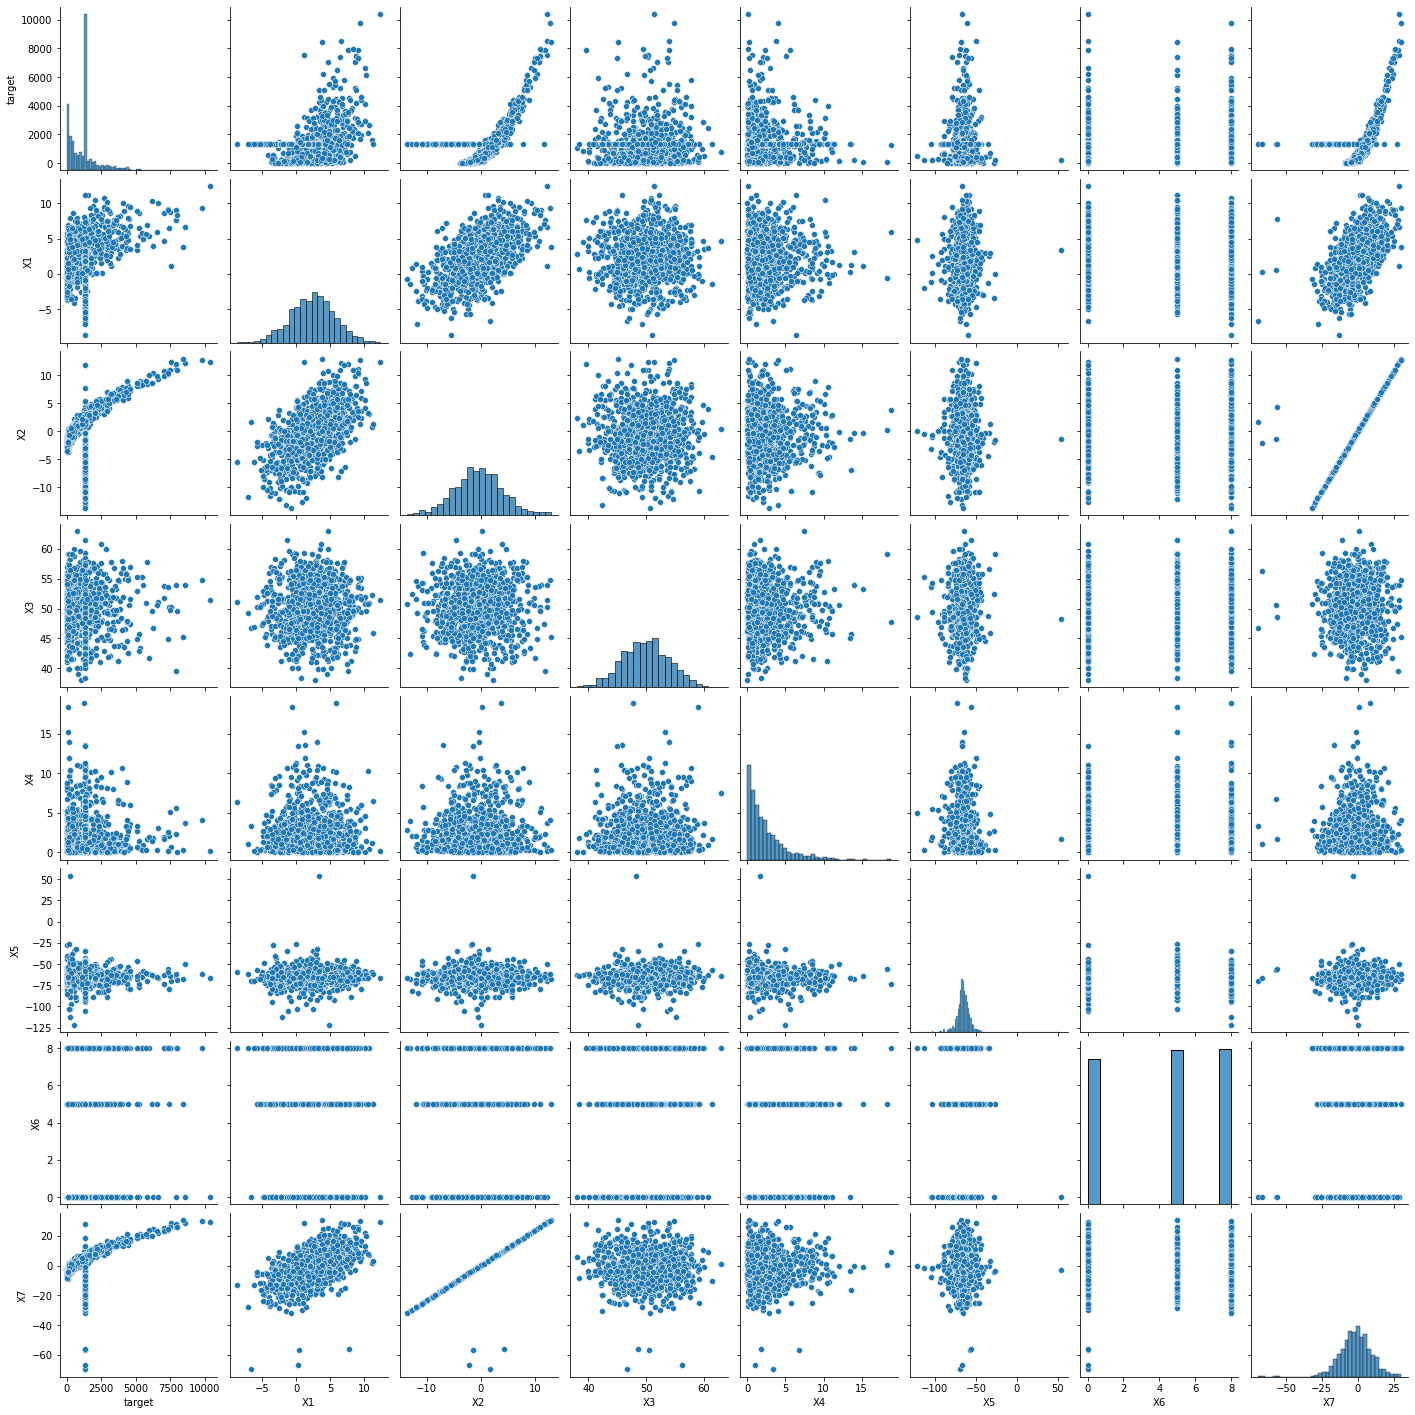

In [22]:
sns.pairplot(df2, diag_kind="hist")

Ao analisar o gráfico anterior é possível observar a consequência do preenchimento dos dados faltantes, no qual em diversas distribuições temos a presença de uma “linha”.

### 4.2.5 CORRELAÇÕES

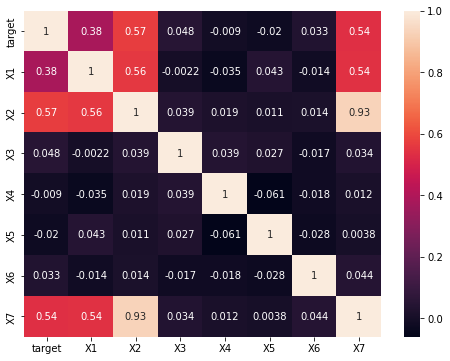

In [23]:
corr_df = df2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Ao analisar a correlação entre as variáveis, nota-se que X4 e X5 possuem correlação próximas a zero as tornando candidatas a não fazer parte do modelo de machine learning. Além disso, X3 e X6 não estão muito acima de zero, porém nesse estudo vamos considerar usá-las.

Outro fator a se observar é a alta correlação entre X2 e X7, sendo possível usar apenas uma delas no modelo de machine learning pois pode-se entender que uma pode “explicar” a outra.


## 4.3 DADOS DE SÉRIE TEMPORAL

In [24]:
#Copia de segurança
df3 = raw_df_time_series.copy()
df3.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,"14,13",20210420
1,A0,25082,UN,"14,13",20210420
2,A0,25430,UN,"14,13",20210922
3,A0,25463,UN,"12,84",20210209
4,A0,25800,UN,"12,84",20210209


### 4.3.1 DIMENSÃO

In [25]:
print( 'Número de observações: {}'.format( df3.shape[0] ) )
print( 'Número de variáveis: {}'.format( df3.shape[1] ) )

Número de observações: 4460
Número de variáveis: 5


### 4.3.2 TIPOLOGIA DOS DADOS

In [26]:
df3.dtypes

produto_descricao                         object
produto_quantidade                         int64
produto_unidade_comercial                 object
produto_valor_unitario_comercializacao    object
nota_data_emissao                          int64
dtype: object

Observamos que a variável "nota_data_emissao" está como um tipo "int64" porém deveria ser interpretado como um "datatime". Além disso, o Valor unitario está como string e deveria ser float.

In [27]:
#Convertendo de int para datatime.
df3['nota_data_emissao'] = pd.to_datetime(df3['nota_data_emissao'], format='%Y%m%d')

In [28]:
df3.dtypes

produto_descricao                                 object
produto_quantidade                                 int64
produto_unidade_comercial                         object
produto_valor_unitario_comercializacao            object
nota_data_emissao                         datetime64[ns]
dtype: object

In [29]:
df3['produto_valor_unitario_comercializacao'] = df3['produto_valor_unitario_comercializacao'].str.replace(",", ".").astype(float)

In [30]:
df3.head(1)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,2021-04-20


### 4.3.3 DADOS AUSENTES

In [31]:
df3.isna().sum()

produto_descricao                         0
produto_quantidade                        0
produto_unidade_comercial                 0
produto_valor_unitario_comercializacao    0
nota_data_emissao                         0
dtype: int64

Não temos dados faltantes.

### 4.3.4 DESCRIÇÃO ESTATÍSTICA E OUTROS

Para os dados númericos:
____

In [32]:
var_num = df3.select_dtypes( include=['int64', 'float64','int32', 'float32'] )

In [33]:
m = desc_num(var_num)
m

,attributes,min,max,range,mean,median,std,assimetria,curtose
0,produto_quantidade,0.00,42000.0000,42000.0000,424.202242,72.00,2036.744387,11.123297,143.184011
1,produto_valor_unitario_comercializacao,0.62,1812.3904,1811.7704,20.508176,11.42,44.421217,29.987978,1187.157515


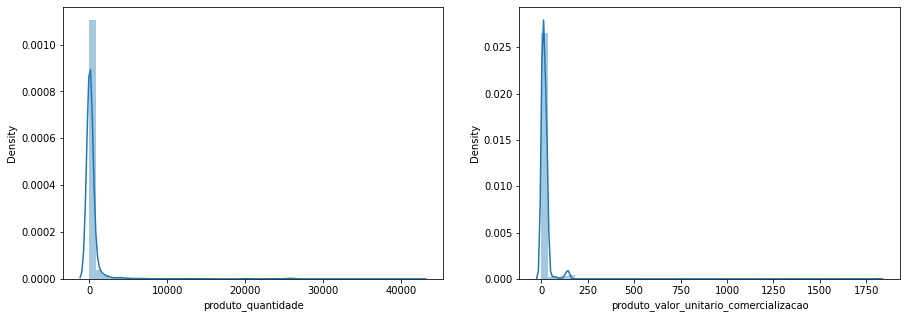

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.title('Histograma dos dados x1 e x2.')

plt.subplot( 1, 2, 1 )
sns.distplot( df3['produto_quantidade'], kde=True )

plt.subplot( 1, 2, 2 )
sns.distplot( df3['produto_valor_unitario_comercializacao'], kde=True )

plt.show()

____
Para os dados categóricos
___

In [35]:
var_cat = df3.select_dtypes( exclude=['int64', 'float64', 'int32', 'float32','datetime64[ns]'] )

var_cat.apply( lambda x: x.unique().shape[0] )

produto_descricao            32
produto_unidade_comercial     5
dtype: int64

Temos 32 produtos e 5 unidade de produto.

In [36]:
var_cat['produto_descricao'].value_counts().index.shape

(32,)

Temos no total 32 produtos. O produto B0 é um forte candidato a ser estudado devido sua quantidade de observações.

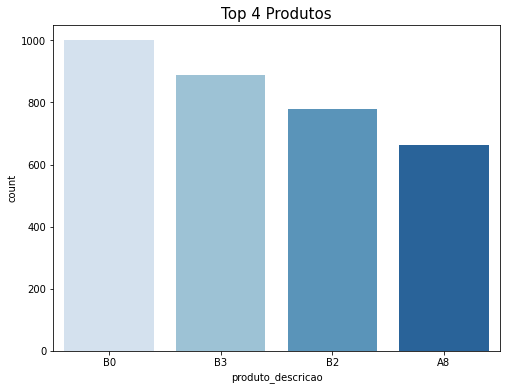

In [37]:
maiores_prod = df3['produto_descricao'].value_counts().index[0:4]

plt.figure(figsize=(8, 6))

# Filtro com os top 3 origens.
ax = sns.countplot(x = 'produto_descricao',  data = df3, order = df3['produto_descricao'].value_counts().index[0:4], palette = 'Blues')
ax.set_title('Top 4 Produtos', fontsize = 15)
plt.show()

O produto B0 é um forte candidato a ser estudado devido sua quantidade de observações.

In [38]:
var_cat['produto_unidade_comercial'].value_counts()

UN    4376
KG      35
MI      35
MG      10
FR       4
Name: produto_unidade_comercial, dtype: int64

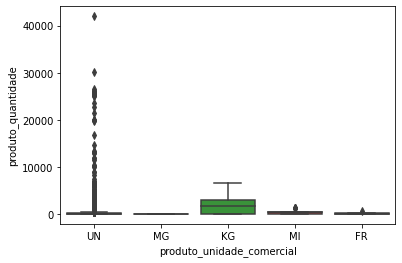

In [39]:
sns.boxplot( x='produto_unidade_comercial', y='produto_quantidade', data=df3 )

### 4.3.5 PRODUTO B0

In [92]:
# Filtrando B0
df3_b0 = df3[df3['produto_descricao'] == 'B0']
df3_b0.reset_index()

,index,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,52,B0,2,UN,32.0200,2021-06-10
1,53,B0,60,UN,29.0900,2021-02-28
2,54,B0,60,UN,32.0200,2021-05-08
3,55,B0,60,UN,32.0200,2021-07-24
4,56,B0,120,UN,29.0900,2021-03-29
...,...,...,...,...,...,...
995,4402,B0,240,UN,29.0900,2020-12-08
996,4403,B0,240,UN,29.0900,2020-12-08
997,4422,B0,60,UN,29.5000,2020-12-11
998,4457,B0,11400,UN,4.6477,2021-02-26


In [93]:
print('Primeira data de observação: ',df3_b0['nota_data_emissao'].min())
print('Ultima data de observação: ',df3_b0['nota_data_emissao'].max())

Primeira data de observação:  2020-10-01 00:00:00
Ultima data de observação:  2021-09-30 00:00:00


In [94]:
print('O menor valor unitario comercializado: ',df3_b0['produto_valor_unitario_comercializacao'].min())
print('O maior valor unitario comercializado: ',df3_b0['produto_valor_unitario_comercializacao'].max())

O menor valor unitario comercializado:  0.62
O maior valor unitario comercializado:  32.47


Valores comercializados com diferença grande.

In [95]:
df3_b0['produto_unidade_comercial'].value_counts()

UN    1000
Name: produto_unidade_comercial, dtype: int64

O produto B0 é comercializado em Unidades (UN).

In [96]:
# Agrupar e somar por data os dados.
df3_b0_new= df3_b0.groupby([df3_b0['nota_data_emissao'].dt.date]).sum()

df3_b0_new.head()

,produto_quantidade,produto_valor_unitario_comercializacao
nota_data_emissao,,
2020-10-01,120,29.50
2020-10-02,14,0.97
2020-10-05,1,0.97
2020-10-07,30,2.64
2020-10-08,1,0.88


In [97]:
df3_b0_new.dtypes

produto_quantidade                          int64
produto_valor_unitario_comercializacao    float64
dtype: object

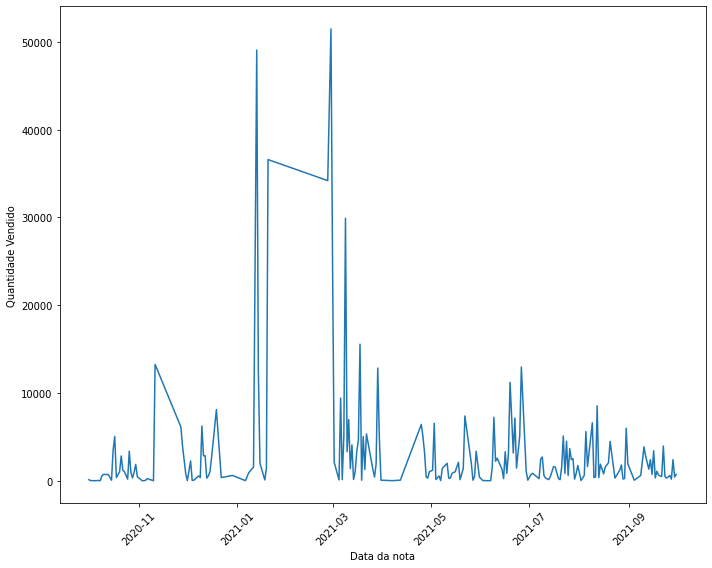

In [98]:
plt.figure(figsize=(10, 8))
plt.plot(df3_b0_new.index,df3_b0_new['produto_quantidade'])
plt.xticks(rotation=45)
plt.xlabel('Data da nota')
plt.ylabel('Quantidade Vendido')
plt.tight_layout()

A demanda pelo produto tem seu pico entre os meses 1 e 3. Logo pode ser um produto relacionado a esse período do ano.

In [99]:
df3_b0_new_t = df3_b0_new.copy()

df3_b0_new_t['Data'] = df3_b0_new_t.index

df3_b0_new_t['Data'] = pd.to_datetime(df3_b0_new_t['Data'])

df3_b0_new_t.dtypes

produto_quantidade                                 int64
produto_valor_unitario_comercializacao           float64
Data                                      datetime64[ns]
dtype: object

## 4.4 DADOS DE RECEITA

In [48]:
#copia de segurança
df4 = raw_df_receitas.copy()
df4.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


No conjunto de dados de receitas temos as colunas ‘directions’, ‘categories’ e ‘ingredients’ como vetores.

### 4.4.1 DIMENSÃO

In [49]:
print( 'Número de observações: {}'.format( df4.shape[0] ) )
print( 'Número de variáveis: {}'.format( df4.shape[1] ) )

Número de observações: 20130
Número de variáveis: 11


### 4.4.2 TIPOLOGIA DOS DADOS

In [50]:
df4.dtypes

directions                  object
fat                        float64
date           datetime64[ns, UTC]
categories                  object
calories                   float64
desc                        object
protein                    float64
rating                     float64
title                       object
ingredients                 object
sodium                     float64
dtype: object

### 4.4.3 DADOS AUSENTES

In [183]:
df4.isna().sum()

directions       19
fat            4222
date             19
categories       19
calories       4154
desc           6635
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

Observamos que existem muitos dados faltantes no conjunto de dados. É preciso verificar se é uma ausência ou apenas a informação é algo vazio, como por exemplo, a receita não tem proteína ou não há descrição para a receita. Para esse conjunto de dados não vamos fazer nenhum processamento nos dados faltantes rebuscado, pois estamos interessados apenas em estudá-los. Entretanto, a fim de facilitar o estudo, irei excluir os dados faltantes.

In [184]:
df4 = df4.dropna()

### 4.4.4 DESCRIÇÃO ESTATÍSTICA E OUTROS

PARA OS DADOS NÚMERICOS
____

In [185]:
# seleção de dados númericos
var_num = df4.select_dtypes( include=['int64', 'float64','int32', 'float32'] )

In [186]:
m = desc_num(var_num)
m

,attributes,min,max,range,mean,median,std,assimetria,curtose
0,fat,0.0,1722763.0,1722763.0,400.612368,19.000,23806.244300,71.159873,5127.868793
1,calories,0.0,30111218.0,30111218.0,7403.781863,351.000,418845.063271,69.917776,4995.952302
2,protein,0.0,236489.0,236489.0,121.733503,9.000,4553.173113,47.071443,2243.755955
3,rating,0.0,5.0,5.0,3.804558,4.375,1.263058,-2.041675,3.609027
4,sodium,0.0,27675110.0,27675110.0,7275.736143,327.000,388628.841427,68.444707,4820.604868


Nessa tabela temos muitas informações. A variável 'fat' possui um range alto e provavelmente outliers, uma vez que sua média é 346 e o máximo é 1722763, uma análise similar temos para as outras variáveis, exceto o rating. O rating podemos ver que fica entre 0 e 5.

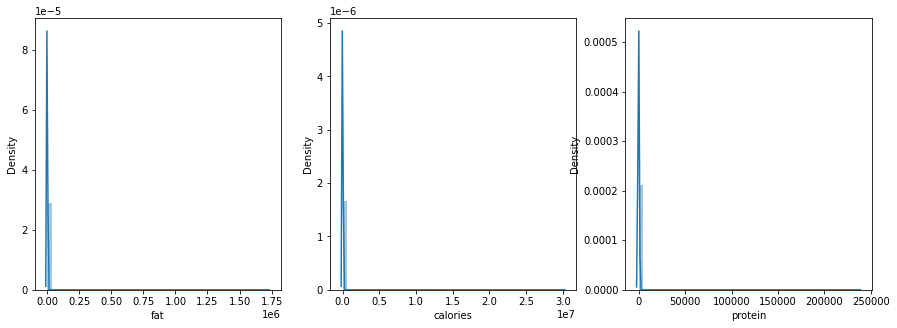

In [187]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.subplot( 1, 3, 1 )
sns.distplot( df4['fat'], kde=True )

plt.subplot( 1, 3, 2 )
sns.distplot( df4['calories'], kde=True )

plt.subplot( 1, 3, 3 )
sns.distplot( df4['protein'], kde=True)

plt.show()

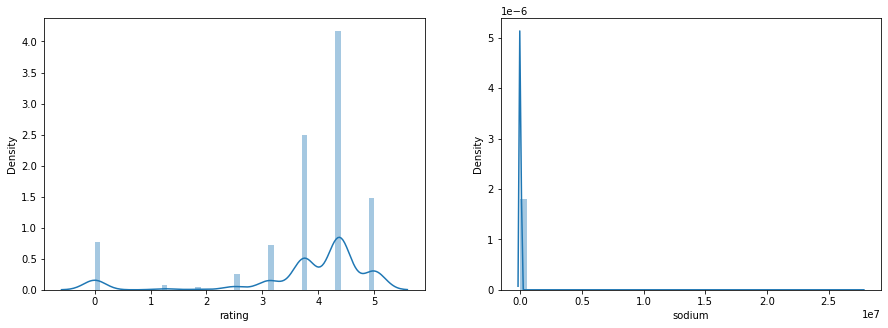

In [188]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.subplot( 1, 2, 1 )
sns.distplot( df4['rating'], kde=True)

plt.subplot( 1, 2, 2 )
sns.distplot( df4['sodium'], kde=True)
plt.show()

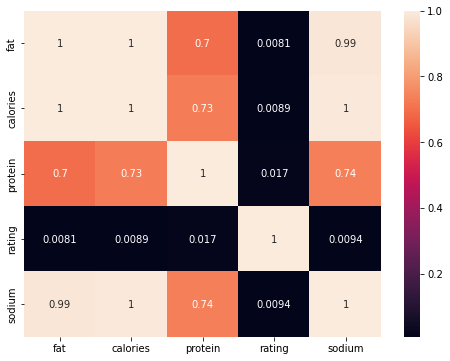

In [189]:
# Correlações
corr_df = var_num.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

De acordo com a figura anterior, podemos ver que a quantidade de ‘fat’ está diretamente ligada a ‘calories’, essa informação faz muito sentido, pois a gordura é uma grande fonte de calorias. De um modo geral, as quantidades de ‘fat’, ‘calories’, ‘protein’ e ‘sodium’ são diretamente proporcionais e possuem uma correlação alta. Além disso, podemos ver que o rating não está muito correlacionado com as outras variáveis e, provavelmente, pelo seu sabor e preparo.

____
PARA OS DADOS CATEGÓRICOS
____

In [190]:
# seleção de variáveis categóricas
var_cat = df4.select_dtypes( exclude=['int64', 'float64', 'int32', 'float32','datetime64[ns]'] )

var_cat.columns

Index(['directions', 'date', 'categories', 'desc', 'title', 'ingredients'], dtype='object')

In [191]:
# quantidade de categorias
print('Quantidade de categorias: ',var_cat['categories'].value_counts().index.shape)

Quantidade de categorias:  (9562,)


#### 4.4.4.1 RECEITAS COM 'POTATO'

In [211]:
df4_potato = []

for index, row in df4.iterrows():
  if ('Potato' in row['title']):
    df4_potato.append(row)

df4_potato = pd.DataFrame(df4_potato)

In [212]:
print('Quantidade de receitas com Potato: ',df4_potato.shape[0])

Quantidade de receitas com Potato:  469


In [200]:
df4_potato.describe()

,fat,calories,protein,rating,sodium
count,469.000000,469.000000,469.000000,469.000000,469.000000
mean,30.876333,547.823028,21.123667,3.888593,573.441365
std,45.063508,553.626664,30.106890,1.006182,923.969768
min,1.000000,19.000000,1.000000,0.000000,5.000000
25%,12.000000,283.000000,5.000000,3.750000,130.000000
50%,19.000000,380.000000,9.000000,4.375000,315.000000
75%,31.000000,600.000000,24.000000,4.375000,653.000000
max,513.000000,5545.000000,234.000000,5.000000,11451.000000


- Receitas com 'Potato'possuem uma média de 547.8 'calories'.
- Receitas com 'Potato' possui uma média de rating de 3.8.
- Receitas com 'Potato' possui uma média de 'fat' relativamente baixa com relação a todas receitas.


#### 4.4.4.2 RECEITAS COM 'CHEESE'

In [203]:
df4_cheese = []

for index, row in df4.iterrows():
  if ('Cheese' in row['title']):
    df4_cheese.append(row)

df4_cheese = pd.DataFrame(df4_cheese)

In [204]:
print('Quantidade de receitas com Cheese: ',df4_cheese.shape[0])

Quantidade de receitas com Cheese:  551


In [205]:
df4_cheese.describe()

,fat,calories,protein,rating,sodium
count,551.000000,551.000000,551.000000,551.000000,551.000000
mean,32.880218,538.079855,17.323049,4.024501,637.802178
std,39.003825,628.337385,21.905686,0.933786,903.249670
min,1.000000,13.000000,0.000000,0.000000,23.000000
25%,16.000000,261.500000,7.000000,3.750000,227.500000
50%,25.000000,422.000000,12.000000,4.375000,430.000000
75%,39.000000,639.000000,21.000000,4.375000,748.500000
max,535.000000,8624.000000,327.000000,5.000000,13875.000000


- Receitas com 'Cheese'possuem uma média de 538 'calories', um pouco menos com relação a receitas com 'Potato'.
- Receitas com 'Cheese' possui uma média de rating de 4.02, ficando superior com relação a receitas com 'Potato'. 
- Receitas com 'Cheese' possui uma média de 'fat' relativamente baixa com relação a todas receitas.

#### 4.4.4.3 RECEITAS COM 'POTATO' E 'CHEESE'

In [206]:
df4_PC = []

for index, row in df4.iterrows():
  if ('Cheese' in row['title']) and ('Potato' in row['title']):
    df4_PC.append(row)

df4_PC = pd.DataFrame(df4_PC)

In [207]:
print('Quantidade de receitas com Cheese e Potato: ',df4_PC.shape[0])

Quantidade de receitas com Cheese e Potato:  33


In [208]:
df4_PC.describe()

,fat,calories,protein,rating,sodium
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,22.424242,432.151515,12.727273,4.147727,489.303030
std,9.721208,183.875318,5.832413,0.463991,335.692613
min,9.000000,195.000000,3.000000,3.125000,108.000000
25%,16.000000,331.000000,9.000000,3.750000,225.000000
50%,20.000000,383.000000,11.000000,4.375000,453.000000
75%,25.000000,472.000000,15.000000,4.375000,613.000000
max,54.000000,1201.000000,27.000000,5.000000,1384.000000


#### 4.4.4.4 RECEITAS COM MENOS DE 4 INGREDIENTES

In [216]:
df4_4 = []

for index, row in df4.iterrows():
  if len(row['ingredients']) <=4:
    df4_4.append(row)

df4_4 = pd.DataFrame(df4_4)

In [217]:
print('Quantidade de receitas com 4 ou menos ingredientes: ',df4_4.shape[0])

Quantidade de receitas com 4 ou menos ingredientes:  787


In [218]:
df4_4.describe()

,fat,calories,protein,rating,sodium
count,787.000000,787.000000,787.000000,787.000000,787.000000
mean,15.513342,324.846252,7.095299,3.250476,279.791614
std,66.420595,1389.442436,24.627191,1.721084,1056.577866
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,118.000000,1.000000,2.500000,6.000000
50%,5.000000,202.000000,2.000000,3.750000,27.000000
75%,15.000000,283.500000,5.000000,4.375000,187.500000
max,1007.000000,22312.000000,332.000000,5.000000,13820.000000


- Receitas com até 4 ingredientes possuem média inferior de rating com relação a todas as receitas.
- Receitas com até 4 ingredientes possuem média de fat inferior com relação a receitas de potato e/ou cheese.

#### 4.4.4.5 ANÁLISE GRÁFICA

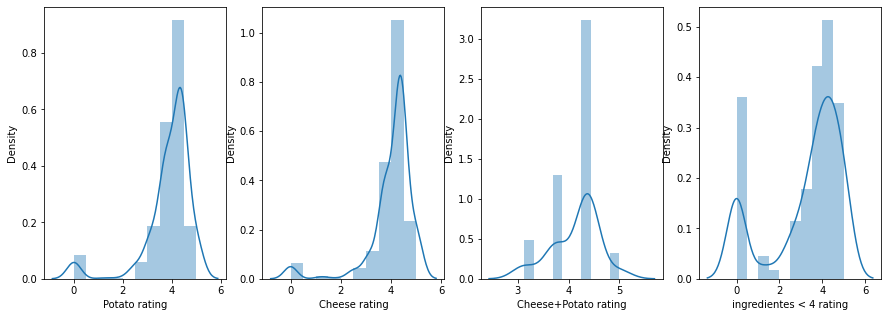

In [224]:
fig, ax = plt.subplots(figsize=(15, 5))


plt.subplot( 1, 4, 1 )
sns.distplot( df4_potato['rating'], kde=True, axlabel= 'Potato rating', bins = 10 )

plt.subplot( 1, 4, 2 )
sns.distplot( df4_cheese['rating'], kde=True, axlabel= 'Cheese rating', bins = 10 )

plt.subplot( 1, 4, 3 )
sns.distplot( df4_PC['rating'], kde=True, axlabel= 'Cheese+Potato rating',bins = 10 )

plt.subplot( 1, 4, 4 )
sns.distplot( df4_4['rating'], kde=True, axlabel= 'ingredientes < 4 rating',bins = 10 )

plt.show()

# 5.0 MODELOS DE MACHINE LEARNING

## 5.1 CLASSIFICADOR

Existem diversos modelos de machine learning para fazer uma classificação, porém vamos usar a regressão logística, por sua simplicidade e por ser dados com um comportamento de separação linear. Além disso, o modelo Decision Tree Classifier por sua facilidade em identificar o peso das variáveis.

In [ ]:
df1.sample()

,x1,x2,target
105,0.020929,0.452126,1


### 5.1.1 MODELO

#### 5.1.1.1 REGRESSÃO LOGISTICA

In [54]:
X = df1[['x1','x2']]
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

pred_clf = clf.predict(X_test)

scor_clf = clf.score(X_test, y_test)*100
scor_clf

82.58706467661692

#### 5.1.1.2 DECISION TREE CLASSIFIER

In [ ]:
# Repeated KFold
srkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Inicializando hiperparametros e classificador

hypeparameters_dt = {
    'criterion': ["gini", "entropy"],
    'max_depth': [5, 10, 25],
    'min_samples_leaf': [1, 5, 10, 50]
}
clf_dt_gs = DecisionTreeClassifier()

# Inicializando busca paramentos
gs_dt = GridSearchCV(clf_dt_gs, param_grid= hypeparameters_dt, cv=skf, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
clf_dt1 = gs_dt.fit(X,y).best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
param_dt1 = clf_dt1.get_params

In [ ]:
y_pred_clf = clf_dt1.predict(X_test)

In [ ]:
sco_clf_dt1 = score(y_test, y_pred_clf)
sco_clf_dt1

0.8955223880597015

### 5.1.2 AVALIAÇÃO

#### 5.1.2.1 REGRESSÃO LOGISTICA

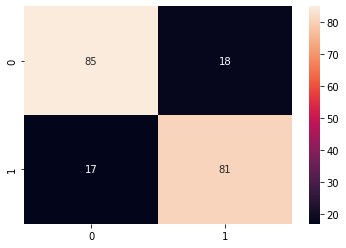

In [ ]:
# Matriz de confusão
cm_RG = confusion_matrix(y_test, pred_clf)
sns.heatmap(cm_RG,cbar=True, annot=True);

In [ ]:
# Report
print(classification_report(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       103
           1       0.82      0.83      0.82        98

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201



Precision = informação de quantas observações o modelo classificou corretamente (Exemplo: de todos os casos que o modelo previu que era inclinado à direita, quantos realmente o eram.)

Recall = analisa entre todas instâncias da classe, quantos, de fato, realmente o modelo conseguiu prever como pertencente àquela classe.

F1-Score = Média harmônica entre precision e recall

Support = Número de ocorrências da classe no conjunto de dados (no caso, no conjunto de teste)

#### 5.1.2.2 DECISION TREE CLASSIFIER

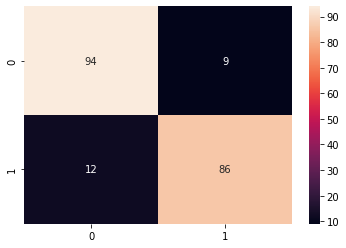

In [ ]:
# Matriz de confusão
cm_DTC = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm_DTC,cbar=True, annot=True);

In [ ]:
# Report
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       103
           1       0.91      0.88      0.89        98

    accuracy                           0.90       201
   macro avg       0.90      0.90      0.90       201
weighted avg       0.90      0.90      0.90       201



### 5.1.3 CONCLUSÃO

Obtemos um melhor resultado com o modelo de árvore de decisão (decision tree), dois motivos foram a busca por hiper parâmetros e a robustez entre os modelos. Além disso, não houve enviesamento nos modelos.

## 5.2 REGRESSÃO

Para a Regressão vamos usar oS modeloS de random forest regression e regressão linear. Um por ser um modelo mais básico e outro por ser um pouco mais complexo e possivelmente traz melhores resultados.

### 5.2.1 MODELO

In [69]:
df2.sample()

,target,X1,X2,X3,X4,X5,X6,X7
992,426.392647,1.975293,0.153298,46.217016,1.88069,-49.568707,5,0.360251


In [71]:
X = df2[['X1','X2','X3','X6']]
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

#### 5.2.1.1 RANDOM FOREST

In [72]:
# Definição do Grid 
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
# Função Grid Search
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [73]:
model_rfr = CV_rfr.fit(X,y).best_estimator_

#### 5.2.1.2 REGRESSÃO LINEAR

In [74]:
# modelO reg linear
lr = LinearRegression().fit( X_train, y_train )

# predição
y_prediction = lr.predict( X_test )

### 5.2.2 AVALIAÇÃO

#### 5.2.2.1 RANDOM FOREST

In [75]:
y_pred = model_rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
r2 = r2_score(y_test, y_pred)
#lasso = model_rfr.Lasso()

print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2)
#print(cross_val_score(lasso, X, y, cv=3))

mse:  97673.7369084103
rmse:  312.5279778010447
r2:  0.9399661214768094


#### 5.2.2.2 REGRESSÃO LINEAR

In [76]:
mse = mean_squared_error(y_test, y_prediction)
rmse = mse**.5
r2 = r2_score(y_test, y_prediction)

print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2)

mse:  1165654.2252909509
rmse:  1079.6546787241516
r2:  0.2835459523087498


### 5.2.3 CONCLUSÃO

O modelo do random forest obteve os melhores resultados tendo um menor RMSE e um valor para o R2 mais próximo de 1.

## 5.3 SERIE TEMPORAL - REGRESSÃO

Para a regressão de series temporais, vamos usar o random forest. Além disso, o intervalo de tempo escolhido será o dia.

In [77]:
df3_b0_new_t.sample()

,produto_quantidade,produto_valor_unitario_comercializacao,Data
nota_data_emissao,,,
2021-08-13,360,64.49,2021-08-13


In [125]:
df3_corr = df3_b0_new_t.copy()
# Tratamento da data para mes e dia da semana para fazer a correlação.
df3_corr['ano'] = df3_corr['Data'].dt.year
df3_corr['mes'] = df3_corr['Data'].dt.month
df3_corr['dia'] = df3_corr['Data'].dt.day

df3_corr = df3_corr.drop(['Data'], axis = 1)

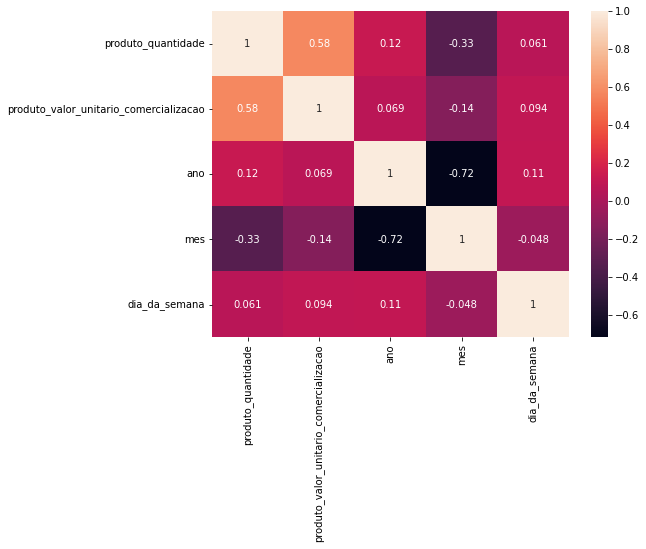

In [124]:
corr_df = df3_corr.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

A variável dia é a que tem menos influência na variável produto_quantidade.  

In [138]:
# train
X_train = df3_b0_new_t[df3_b0_new_t['Data'] < '2021-07-05']
X_train = X_train.reset_index(drop=True)
y_train = X_train['produto_quantidade']


# test
X_test = df3_b0_new_t[df3_b0_new_t['Data'] >= '2021-07-05']
X_test = X_test.reset_index(drop=True)
y_test = X_test['produto_quantidade']

print( 'Training Min Date: {}'.format( X_train['Data'].min() ) )
print( 'Training Max Date: {}'.format( X_train['Data'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['Data'].min() ) )
print( 'Test Max Date: {}'.format( X_test['Data'].max() ) )

Training Min Date: 2020-10-01 00:00:00
Training Max Date: 2021-07-03 00:00:00

Test Min Date: 2021-07-05 00:00:00
Test Max Date: 2021-09-30 00:00:00


In [139]:
# Tratando o datetime
X_train['ano'] = X_train['Data'].dt.year
X_train['mes'] = X_train['Data'].dt.month
X_train['dia'] = X_train['Data'].dt.day
X_train = X_train.drop(['Data','produto_valor_unitario_comercializacao','produto_quantidade'], axis = 1)

X_test['ano'] = X_test['Data'].dt.year
X_test['mes'] = X_test['Data'].dt.month
X_test['dia'] = X_test['Data'].dt.day
X_test = X_test.drop(['Data','produto_valor_unitario_comercializacao','produto_quantidade'], axis = 1)

In [140]:
# 4 intervalos de tempo
X_4inter = [[2021,10,1],[2021,10,2],[2021,10,3], [2021,10,4]]

### 5.3.1 MODELO

#### 5.3.1.1 RANDOM FOREST

In [145]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_test )

### 5.3.2 AVALIAÇÃO E PREVISÃO

#### 5.3.2.1 RANDOM FOREST

In [142]:
# performance
rf_result = ml_error( model_name = 'Random Forest Regressor', y = y_test, yhat = yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2076.505758,4.181105,2837.57267


In [143]:
# Previsão para 4 intervalos

previsãop4 = rf.predict( X_4inter )
print(previsãop4)

array([3678.19,  349.12,  778.44,  161.24])

### 5.3.3 CONCLUSÃO

As métricas foram razoáveis para o modelo e obtivemos bons resultados para a previsão dos 4 próximos intervalos. 